# Model 2

## Refine the Data

Create the items , users and the interaction Matrix:-
1. **items**:item id + metadata features
2. **Users**:User id + metadata features
3. **Interaction**: Explicit Matrix and Implicit Matrix

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import re

## Items

For the items, we will keep the following:
- From `items_raw` dataframe
  - movie_id
  - title
  - year (release)
  - genre categories
- From `item_features` dataframe
  - overview
  - language (original_language)
  - runtime
  - vote_average
  - vote_count

## Content Based Filtering

In [3]:
items_raw = pd.read_csv("data/items_raw.csv")
item_features = pd.read_csv("data/item_features.csv")

*1. Get `year` from `release_title`* 

In [4]:
items_raw["release_date"] = pd.to_datetime(items_raw.release_date, infer_datetime_format=True)
items_raw["year"] = items_raw.release_date.apply(lambda x: str(x.year))

*2. Drop `imdb_url`,  `video_release_date` & `release_date`*

In [5]:
items_main = items_raw.drop(['video_release_date', 'release_date',"IMDb_URL"], axis=1).copy()

In [6]:
items_addtl = item_features[['overview', 'original_language', 'runtime', 'vote_average', 'vote_count', "movie_id"]].copy()

In [7]:
items = pd.merge(left=items_main, right=items_addtl, on="movie_id", how="left")

In [8]:
items.head()

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Sci-fi,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,1995,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.9,13765.0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,1,0,0,1995,When a powerful satellite system falls into th...,en,130.0,6.9,2722.0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,1,0,0,1995,It's Ted the Bellhop's first night on the job....,en,98.0,5.7,1912.0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,1995,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.5,678.0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,1,0,0,1995,An agoraphobic psychologist and a female detec...,en,124.0,6.5,601.0


In [9]:
items.overview.isna().sum()

17

In [10]:
items.overview.fillna("None", inplace=True)

In [11]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [12]:
doc=nlp(items["overview"][0])

In [13]:
doc.vector

array([ 2.49380805e-02,  1.74549282e-01, -9.29457471e-02, -4.02068421e-02,
        2.45584920e-02,  2.10599136e-02,  4.59955782e-02, -1.43892854e-01,
        2.23628674e-02,  2.10939479e+00, -1.11910768e-01, -7.78442621e-02,
       -5.78953363e-02, -5.18039986e-02, -4.90232185e-02, -3.90546210e-02,
       -1.63908191e-02,  7.56938040e-01, -1.07308537e-01, -1.58448797e-02,
       -3.28326374e-02, -4.18951176e-02, -2.36957222e-02, -4.90324982e-02,
        3.45998853e-02, -5.01969596e-04, -7.33386278e-02,  8.14125240e-02,
        1.23276107e-03, -3.94272059e-02, -4.45753373e-02,  9.23748016e-02,
       -1.85925841e-01,  1.29784733e-01,  6.92790821e-02, -8.13476965e-02,
        3.25000323e-02,  8.13459679e-02, -4.94984947e-02, -1.00935347e-01,
        8.89295489e-02,  2.81169247e-02,  8.77274945e-03, -3.19957659e-02,
        7.94582665e-02,  9.91719663e-02, -1.07840024e-01, -5.39268330e-02,
       -3.52545083e-02,  1.26066720e-02,  3.39749381e-02, -7.42770284e-02,
       -5.82755692e-02, -

## Overview Embeddings

In [14]:
def word_vec(sentence):
    doc = nlp(sentence)
    return doc.vector

In [15]:
%%time
overview_embedding = items["overview"].apply(word_vec)

CPU times: user 12.3 s, sys: 0 ns, total: 12.3 s
Wall time: 12.3 s


In [16]:
overview_embedding = overview_embedding.to_list()

In [17]:
overview_embedding_list = []
for vec in overview_embedding:
    overview_embedding_list.append(vec.tolist())

In [18]:
len(overview_embedding_list)

1746

In [19]:
overview_embedding_df = pd.DataFrame(overview_embedding_list)

In [20]:
overview_embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.024938,0.174549,-0.092946,-0.040207,0.024558,0.021060,0.045996,-0.143893,0.022363,2.109395,...,-0.164214,0.073254,0.071066,0.005870,-0.047621,-0.005115,0.025926,-0.035420,-0.059641,-0.004321
1,-0.093888,0.154564,-0.033447,0.056894,0.048425,-0.064527,-0.080306,-0.039367,-0.110985,1.967021,...,-0.121204,0.061600,-0.014734,-0.014214,-0.110051,0.068111,0.049110,-0.061887,-0.049966,-0.009412
2,0.024798,0.201679,-0.035214,-0.044371,0.065224,0.011609,-0.008056,-0.141306,0.003372,2.377326,...,-0.125685,0.043005,0.087619,-0.073365,0.035089,-0.006726,-0.003821,-0.012937,-0.014347,0.046458
3,-0.044721,0.126973,-0.104857,-0.019217,0.138141,0.091052,0.026251,-0.202099,0.047526,2.029502,...,-0.125688,0.038220,0.011013,0.041688,0.000462,-0.014254,-0.015342,-0.110975,-0.009556,0.053125
4,0.080059,-0.017512,-0.176883,0.082077,0.056057,-0.022036,-0.042583,-0.109661,0.073444,2.139982,...,-0.184866,0.007139,0.070511,0.089315,0.028993,-0.071459,0.047445,-0.044927,-0.102735,-0.100472


In [21]:
items.columns

Index(['movie_id', 'movie_title', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-fi', 'Thriller', 'War', 'Western', 'year', 'overview',
       'original_language', 'runtime', 'vote_average', 'vote_count'],
      dtype='object')

In [22]:
item_similarity_df = pd.concat([
    items[['movie_id', 'unknown', 'Action', 'Adventure',
       'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-fi', 'Thriller', 'War', 'Western']], 
    overview_embedding_df],
    axis=1)

In [23]:
item_similarity_df.head()

,movie_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,290,291,292,293,294,295,296,297,298,299
0,1,0,0,0,1,1,1,0,0,0,...,-0.164214,0.073254,0.071066,0.005870,-0.047621,-0.005115,0.025926,-0.035420,-0.059641,-0.004321
1,2,0,1,1,0,0,0,0,0,0,...,-0.121204,0.061600,-0.014734,-0.014214,-0.110051,0.068111,0.049110,-0.061887,-0.049966,-0.009412
2,3,0,0,0,0,0,0,0,0,0,...,-0.125685,0.043005,0.087619,-0.073365,0.035089,-0.006726,-0.003821,-0.012937,-0.014347,0.046458
3,4,0,1,0,0,0,1,0,0,1,...,-0.125688,0.038220,0.011013,0.041688,0.000462,-0.014254,-0.015342,-0.110975,-0.009556,0.053125
4,5,0,0,0,0,0,0,1,0,1,...,-0.184866,0.007139,0.070511,0.089315,0.028993,-0.071459,0.047445,-0.044927,-0.102735,-0.100472


## Build nearest neighbor model

In [24]:
from reco.recommend import get_similar
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

## Similarity Matrix Building

In [25]:
%%time
item_distances, item_similar_indices = get_similar(overview_embedding_df, 5)

CPU times: user 728 ms, sys: 0 ns, total: 728 ms
Wall time: 728 ms


In [26]:
item_distances

array([[0.        , 0.87947461, 0.90046233, 0.90100291, 0.90703799],
       [0.        , 0.83929762, 0.84090237, 0.86182834, 0.86279583],
       [0.        , 0.93341957, 0.96300628, 0.96861008, 0.96919233],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.92522434],
       [0.        , 1.10541475, 1.12753751, 1.13292897, 1.1341547 ],
       [0.        , 0.95070647, 0.95350265, 0.95365714, 0.95405593]])

In [34]:
item_similar_indices

array([[   0, 1166, 1417,  731, 1605],
       [   1,  303,  419, 1247, 1251],
       [   2,  976,  494,  161,  451],
       ...,
       [1743, 1472, 1742, 1473, 1730],
       [1744, 1373,   47,   25, 1164],
       [1745,  267,  592, 1646,  595]])

In [35]:
def show_similar(item_index, item_similar_indices):
        
    movie_ids = item_similar_indices[item_index]
    #movie_ids = item_encoder.inverse_transform(s)

    images = []
    for movie_id in movie_ids:
        img_path = 'data/posters/' + str(movie_id+1) + '.jpg'
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

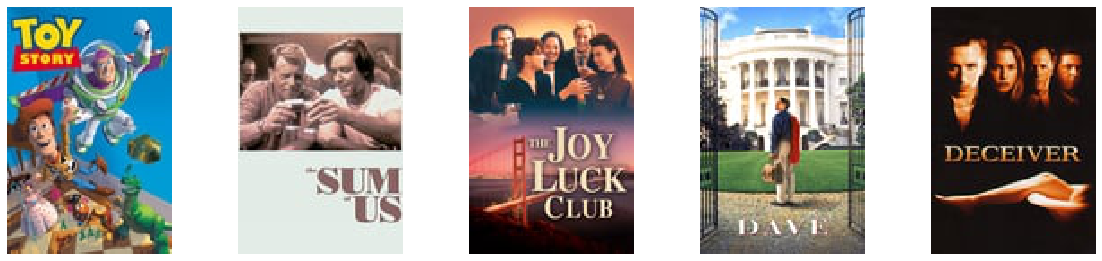

In [42]:
show_similar(0, item_similar_indices)